In [12]:
# In this notebook two type of experiments are considered
# - pure    -> experiments with one simultaneously running MPI task 
# - sharing -> experiments with two simultaneously running MPI tasks

# This experiments may be
# local  -> VMs connect between each other with local linux bridge 
# or
# remote -> VMs connect between each other with remote linux bridge


In [13]:
# Pure experiments

import os
import json
import pandas as pd
from tabulate import tabulate
from collections import OrderedDict


def get_comp_time_pure(results_dir, tasks, sizes, procs, experiments_num):
    """This function parse results file and return computational statistics

    Args:
        results_dir (str): directory with result files.
            Each file has name with following pattern:
            <exec file name>_<task size>_<number of MPI procs>_e_<experiment seq num>.out
            
            Ex:
                lu.W.x_W_8_e_1.out

    Returns:
        dict: key   - task name 
              value - dict with
                  key   - task size
                  value - dict with
                      key   - number of proc
                      value - average computational time

    """
    
    if not os.path.isdir(results_dir):
        raise "Cannot find directory ''%s'" % results_dir
        
    results = {}
    
    for task in tasks:
        if task not in results:
            results[task] = OrderedDict()

        for size in sizes:
            if size not in results[task]:
                results[task][size] = OrderedDict()
            
            for proc in procs:
                if proc not in results[task][size]:
                    results[task][size][proc] = list()

                filename = "%s.%s.x_%s_%s" % (task, size, size, proc)
                for n in range(0, experiments_num):
                    full_path = os.path.join(results_dir, "%s_e_%d.out" % (filename, n))
                    if not os.path.isfile(full_path):
                        results[task][size][proc].append(float("nan"))
                    else:
                        with open(full_path, "r") as f:
                            line = f.readline()
                            while line != "":
                                if "Time in seconds" in line:
                                    results[task][size][proc].append(float(line.split('=')[1]))
                                    break
                                line = f.readline()

                if len(results[task][size][proc]) != 0:
                    results[task][size][proc] = sum(results[task][size][proc]) / float(len(results[task][size][proc]))
                else:
                    results[task][size][proc] = float("nan")

    return results

def print_comp_time_pure(comp_time, tasks):
    for task in tasks:
        df = pd.DataFrame(comp_time[task])
        print("Results for task '%s'" % (task))
        print(df)
        print('\n')

def get_resources_usage():
    # TODO
    pass


# ============================================================

# Read and print computational time
tasks = ["is", "ep", "cg", "lu", "ft"]
sizes = ["S", "W", "A", "B", "C", "D"]
procs = [1, 2, 4, 8, 16]
exp_num = 5

results_pure = get_comp_time_pure("../results/pure_NPB_local/cluster",
                                  tasks, sizes, procs, exp_num)

# print(json.dumps(results, sort_keys = True, indent = 4))
print_comp_time_pure(results_pure, tasks)


# Read and print information about resources usage
res_usage = get_resources_usage()


Results for task 'is'
        S      W      A      B      C   D
1   0.006  0.080  0.546  2.214    NaN NaN
2   0.006  0.060  0.394  1.544  6.020 NaN
4   0.010  0.040  0.230  0.898  3.476 NaN
8   0.018  0.048  0.216  0.674  2.414 NaN
16  0.424  0.948  1.350  1.908  5.156 NaN


Results for task 'ep'
        S      W       A       B        C         D
1   0.896  1.688  12.462  49.386  196.928  3150.274
2   0.530  0.908   6.466  25.718  101.532  1623.076
4   0.282  0.540   3.576  13.848   55.030   882.300
8   0.164  0.306   2.106   8.038   31.574   498.338
16  0.098  0.196   1.374   5.404   21.134   333.168


Results for task 'cg'
        S      W      A        B        C   D
1   0.052  0.296  0.992  100.154      NaN NaN
2   0.090  0.242  0.656   44.996  141.412 NaN
4   0.106  0.200  0.444   26.766   81.296 NaN
8   0.250  0.340  0.476   14.820   47.416 NaN
16  1.574  1.572  2.338   28.452   59.484 NaN


Results for task 'lu'
        S       W       A        B        C         D
1   0.040   

In [14]:
# Sharing experiments
# We have checked yet sharing effect only on tasks with size A
# slowdown coefficient = time with sharing / pure time

# Names of result files
# pure
#     ep.B.x_B_16_e_0.out

# sharing 
#     ep.A.x_ep.A.x_8_4_e_0.out
#     ep.A.x_ep.A.x_8_16.out

from functools import reduce
from copy import deepcopy


def get_comp_time_sharing(dir1, dir2, tasks, procs, experiments_num):
    """This function parse results file and return computational statistics

    Args:
        dir1 and dir2 (str): directory with result files for cluster_1 and cluster_2
            Each file has name with following pattern:
            <exec file name 1>_<exec file name 2>_<number of MPI procs 1>_<number of MPI procs 2>_e_<experiment seq num>.out
            
            Ex:
                lu.A.x_lu.A.x_8_8_e_3.out

    Returns:
        dict: key   - tuple with two task names
              value - dict with
                  key   - tuple with np1, np2, where np is number of processes
                  value - tuple with two corresponding computational times

    """
    
    if not os.path.isdir(dir1):
        raise "Cannot find directory ''%s'" % dir1
        
    if not os.path.isdir(dir2):
        raise "Cannot find directory ''%s'" % dir2
        
    results = {}
    
    for i in range(0, len(tasks)):
        for j in range(i, len(tasks)):
            key_1 = tuple((tasks[i], tasks[j]))
            if key_1 not in results:
                results[key_1] = OrderedDict()

            for np1 in procs:
                for np2 in procs:
#                     print("RUN (%s, %s) (%s, %s)" % (tasks[i], tasks[j], np1, np2))
                    
#                     key_2 = str(np1) + ' ' + str(np2)
                    key_2 = tuple((np1, np2))
                    if key_2 not in results[key_1]:
                        results[key_1][key_2] = list()
                    
                    filename_1 = "%s.A.x_%s.A.x_%s_%s" % (tasks[i], tasks[j], np1, np2)
                    filename_2 = "%s.A.x_%s.A.x_%s_%s" % (tasks[j], tasks[i], np2, np1)
            
                    for n in range(0, experiments_num):
                        full_path_1 = os.path.join(dir1, "%s_e_%d.out" % (filename_1, n))
                        full_path_2 = os.path.join(dir2, "%s_e_%d.out" % (filename_2, n))
                        
                        t1 = float("nan")
                        t2 = float("nan")
                        
                        if os.path.isfile(full_path_1):
                            with open(full_path_1, "r") as f:
                                line = f.readline()
                                while line != "":
                                    if "Time in seconds" in line:
                                        t1 = float(line.split('=')[1])
                                        break
                                    line = f.readline()
                        
                        if os.path.isfile(full_path_2):
                            with open(full_path_2, "r") as f:
                                line = f.readline()
                                while line != "":
                                    if "Time in seconds" in line:
                                        t2 = float(line.split('=')[1])
                                        break
                                    line = f.readline()
                        
                        results[key_1][key_2].append([t1, t2])

                    if len(results[key_1][key_2]) != 0:
                        t1_sum = reduce(lambda a,b: a+b[0], results[key_1][key_2], 0)

                        t2_sum = reduce(lambda a,b: a+b[1], results[key_1][key_2], 0)
                        
                        results[key_1][key_2] = tuple((t1_sum / float(len(results[key_1][key_2])),
                                                       t2_sum / float(len(results[key_1][key_2]))))
                    else:
                        results[key_1][key_2] = tuple((float("nan"), float("nan")))
                    
    return results


def print_comp_time_sharing(comp_time, tasks):
    for i in range(0, len(tasks)):
        for j in range(i, len(tasks)):
            df = pd.DataFrame(comp_time[(tasks[i], tasks[j])])
            print("Results for pair (%s, %s)" % (tasks[i], tasks[j]))
            print(df)
            print('\n')

# ============================================================

# Read and print computational time
tasks = ["is", "ep", "cg", "lu", "ft"]
procs = [4, 8, 16]
exp_num = 1

results_sharing = get_comp_time_sharing(
            "../results/sharing_NPB_size_A_local/cluster_1",
            "../results/sharing_NPB_size_A_local/cluster_2",
            tasks, procs, exp_num)

print("Computational results for sharing experiments".upper())
print_comp_time_sharing(results_sharing, tasks)

# results for pure computation for all tasks with size A
print("Computational results for pure run for all tasks with size A".upper())
for task, task_res in results_pure.items():
    print("Results for '%s'" % task)
    df = pd.DataFrame(task_res)
    print(df['A'], '\n')

COMPUTATIONAL RESULTS FOR SHARING EXPERIMENTS
Results for pair (is, is)
     4                 8                 16            
     4     8     16    4     8     16    4     8     16
0  0.26  0.45  1.46  0.44  0.51  2.44  1.82  2.68  2.87
1  0.34  0.45  2.10  0.46  0.66  2.68  0.53  2.73  2.57


Results for pair (is, ep)
     4                 8                 16            
     4     8     16    4     8     16    4     8     16
0  0.35  0.45  1.83  0.38  1.05  2.57  2.46  2.52  2.89
1  3.61  2.21  2.39  3.66  2.49  2.77  5.17  3.74  3.35


Results for pair (is, cg)
     4                 8                 16            
     4     8     16    4     8     16    4     8     16
0  0.29  0.49  1.70  0.55  0.69  1.28  2.27  2.64  3.18
1  0.54  0.82  2.87  0.76  0.86  1.62  0.96  3.92  4.73


Results for pair (is, lu)
      4                    8                    16              
      4      8      16     4      8      16     4      8      16
0   0.30   0.50   1.21   0.44   1.58   3.2

In [16]:
# Slowdown
# slowdown coefficient = time with sharing divided on pure time
print("Slowdown information".upper())

slowdown_info = deepcopy(results_sharing)
for tasks_pair, procs in slowdown_info.items():
    for procs_pair, t in procs.items():
        t1_p = results_pure[tasks_pair[0]]["A"][procs_pair[0]]
        t2_p = results_pure[tasks_pair[1]]["A"][procs_pair[1]]
        print("(%s,%s) (%2s,%2s) sharing: (%f,%f); pure: (%f,%f); slowdown: (%f,%f)" % 
              (tasks_pair[0], tasks_pair[1], procs_pair[0], procs_pair[1], 
               t[0], t[1], t1_p, t2_p, t[0]/t1_p, t[1]/t2_p))
        
        slowdown_info[tasks_pair][procs_pair] = tuple((t[0]/t1_p , t[1]/t2_p))

SLOWDOWN INFORMATION
(cg,lu) ( 4, 4) sharing: (0.610000,12.910000); pure: (0.444000,12.898000); slowdown: (1.373874,1.000930)
(cg,lu) ( 4, 8) sharing: (0.860000,10.590000); pure: (0.444000,10.432000); slowdown: (1.936937,1.015146)
(cg,lu) ( 4,16) sharing: (1.030000,20.630000); pure: (0.444000,21.306000); slowdown: (2.319820,0.968272)
(cg,lu) ( 8, 4) sharing: (0.820000,13.200000); pure: (0.476000,12.898000); slowdown: (1.722689,1.023414)
(cg,lu) ( 8, 8) sharing: (1.510000,11.230000); pure: (0.476000,10.432000); slowdown: (3.172269,1.076495)
(cg,lu) ( 8,16) sharing: (6.980000,23.850000); pure: (0.476000,21.306000); slowdown: (14.663866,1.119403)
(cg,lu) (16, 4) sharing: (13.760000,23.200000); pure: (2.338000,12.898000); slowdown: (5.885372,1.798728)
(cg,lu) (16, 8) sharing: (19.080000,27.050000); pure: (2.338000,10.432000); slowdown: (8.160821,2.592983)
(cg,lu) (16,16) sharing: (24.820000,38.300000); pure: (2.338000,21.306000); slowdown: (10.615911,1.797616)
(is,is) ( 4, 4) sharing: (0.2

In [17]:
# Print slowdown info
print("Slowdown results for sharing experiments".upper())
print_comp_time_sharing(slowdown_info, tasks)

print(list(slowdown_info[('is', 'is')].keys()))
print(list(slowdown_info[('is', 'is')].values()))

SLOWDOWN RESULTS FOR SHARING EXPERIMENTS
Results for pair (is, is)
         4                             8                              16  \
         4         8         16        4         8          16        4    
0  1.130435  1.956522  6.347826  2.037037  2.361111  11.296296  1.348148   
1  1.478261  2.083333  1.555556  2.000000  3.055556   1.985185  2.304348   

                        
          8         16  
0   1.985185  2.125926  
1  12.638889  1.903704  


Results for pair (is, ep)
         4                             8                              16  \
         4         8         16        4         8          16        4    
0  1.521739  1.956522  7.956522  1.759259  4.861111  11.898148  1.822222   
1  1.009508  1.049383  1.739447  1.023490  1.182336   2.016012  1.445749   

                       
         8         16  
0  1.866667  2.140741  
1  1.775878  2.438137  


Results for pair (is, cg)
         4                             8                             16

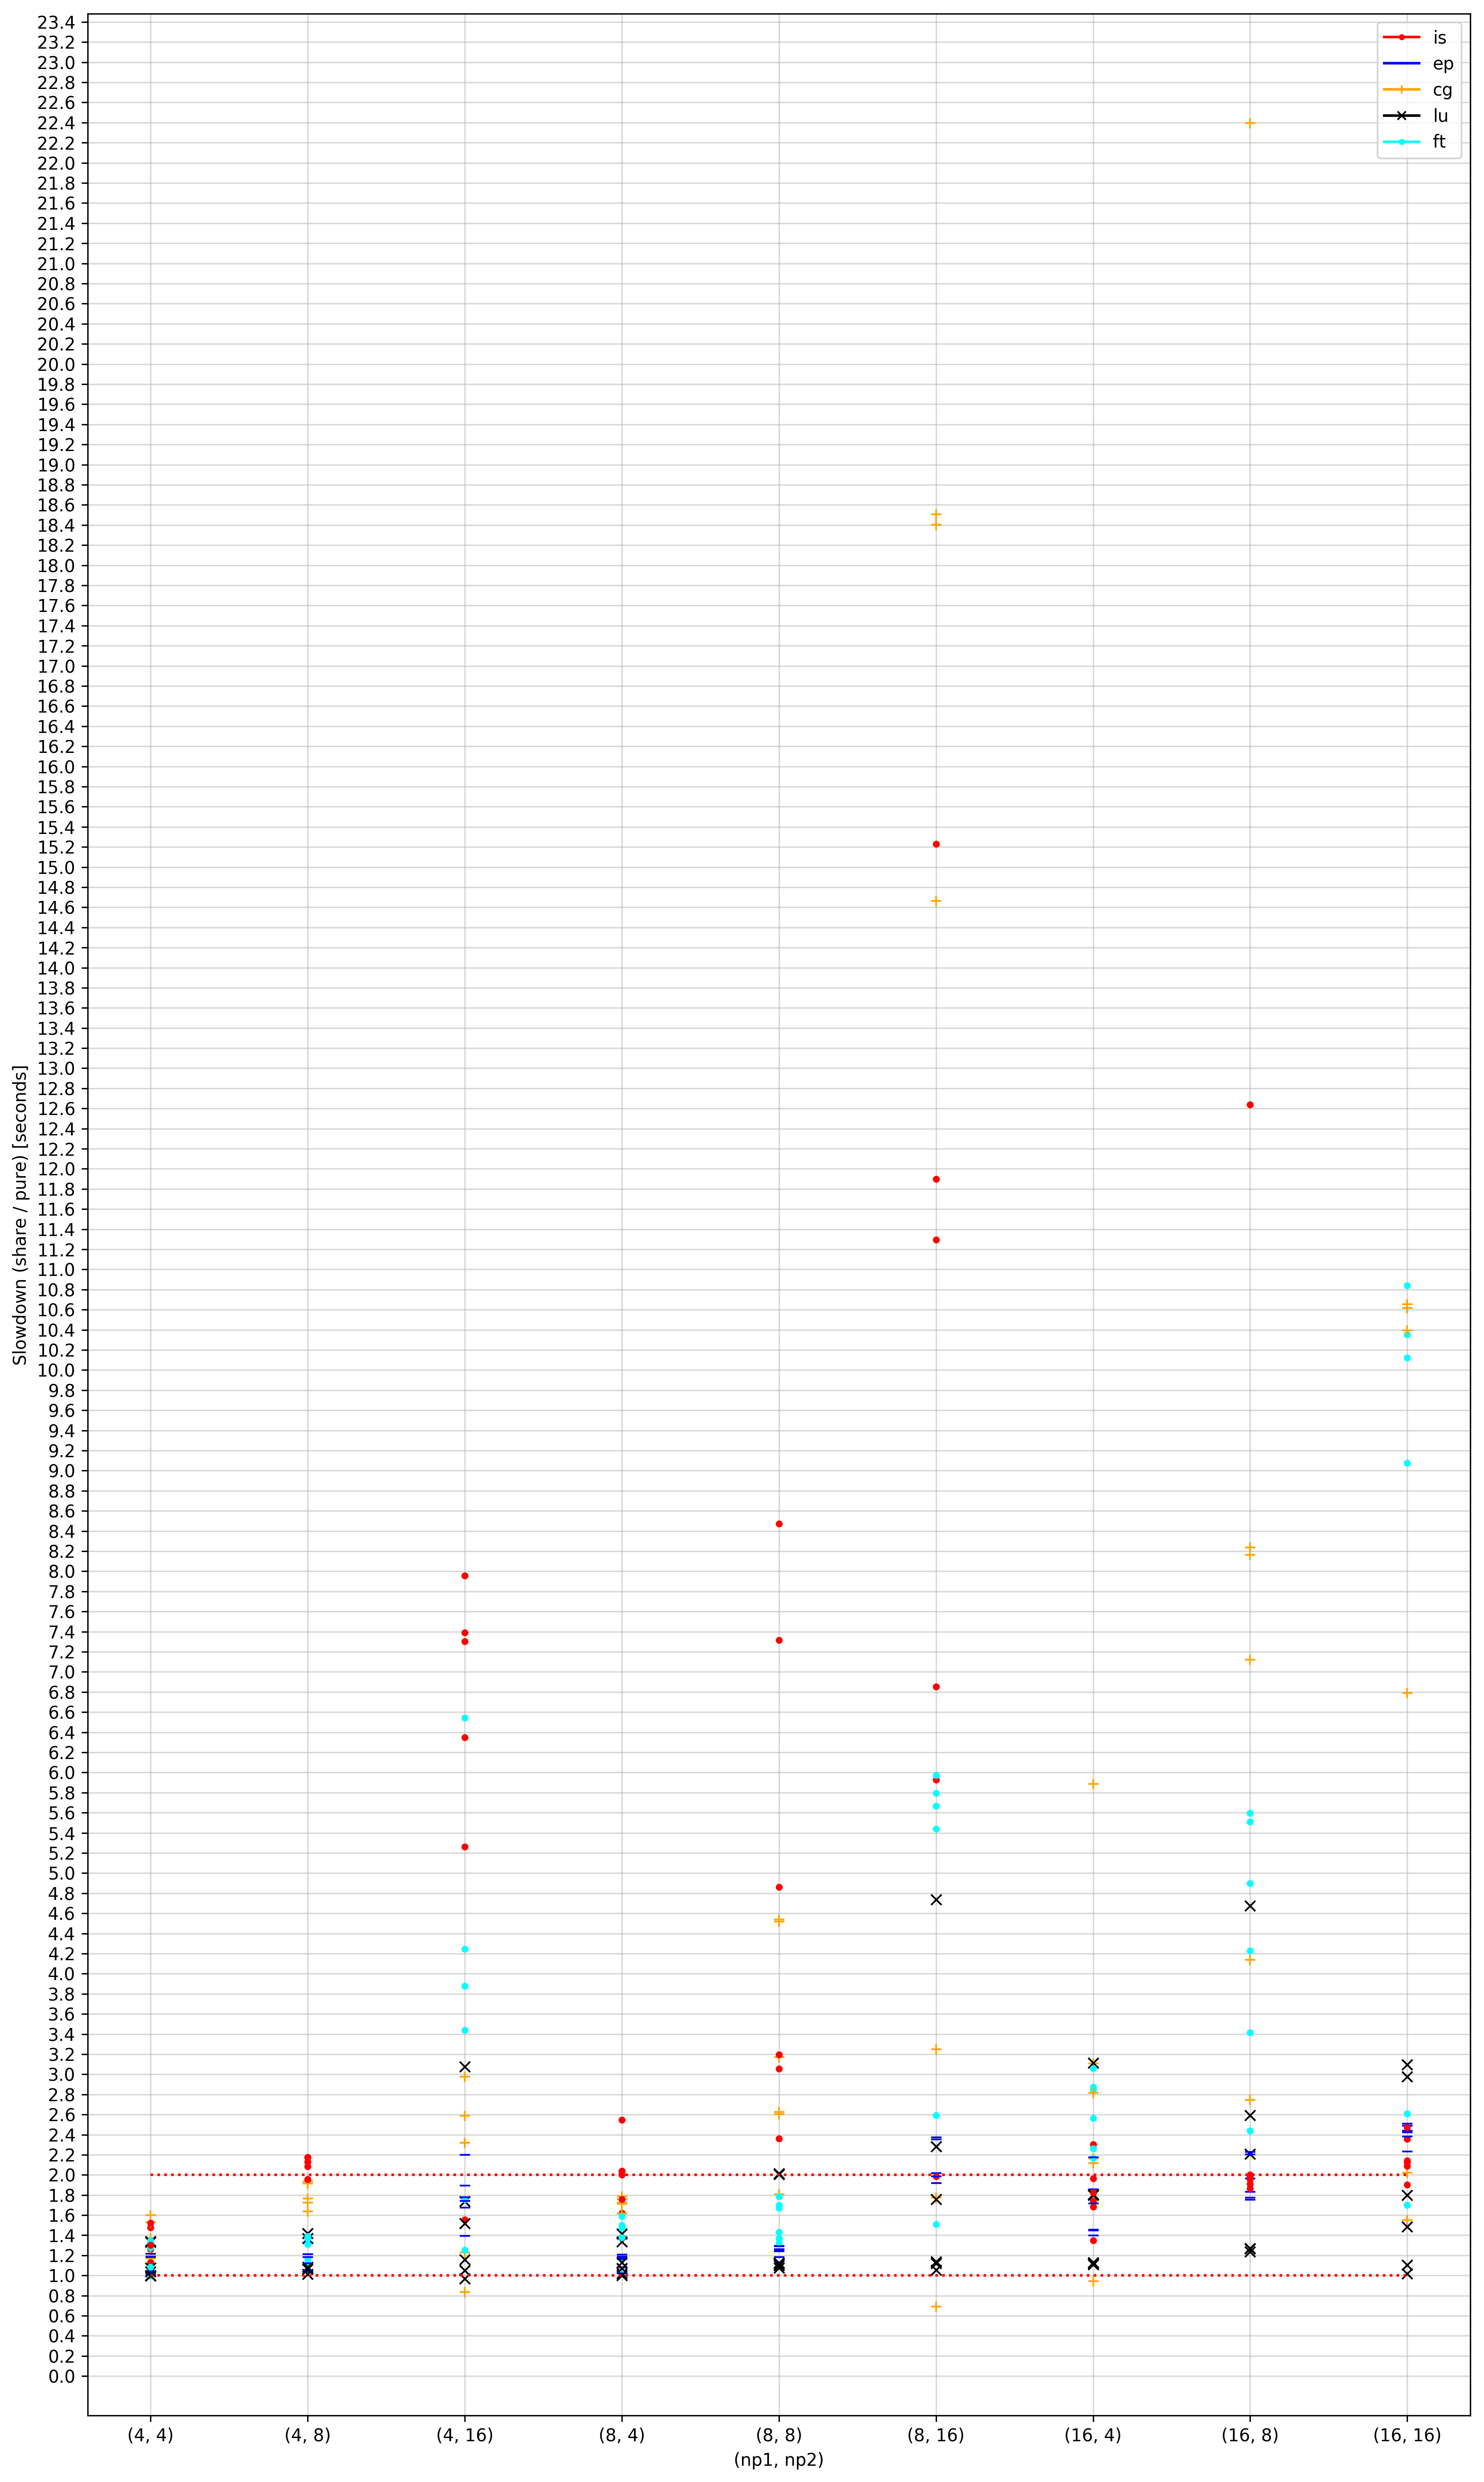

In [42]:
# Draw slowdown info

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline


tasks = ["is", "ep", "cg", "lu", "ft"]
colors = {"is": "red", "ep": "blue", "cg": "orange", "lu": "black", "ft": "cyan"}
markers = {"is": ".", "ep": "_", "cg": "+", "lu": "x", "ft": "."}


fig = plt.figure(figsize=(12,20), dpi=300)
ax = fig.add_subplot(111)

for tasks_pair, procs in slowdown_info.items():
    n = 0
    for procs_pair, sl in procs.items():
        task1 = tasks_pair[0]
        task2 = tasks_pair[1]
        sl1 = sl[0]
        sl2 = sl[1]
        
        ax.plot(n, sl1, color=colors[task1], marker=markers[task1])
        ax.plot(n, sl2, color=colors[task2], marker=markers[task2])
        
        n += 1

# Draw null slowdown line and slodown with factor 2
null_slowdown_x = np.linspace(0, len(slowdown_info[('is', 'is')].keys())-1, num=2)
null_slowdown_y = np.zeros(2)
ax.plot(null_slowdown_x, null_slowdown_y+1, color="red", linestyle=":")

ax.plot(null_slowdown_x, null_slowdown_y+2, color="red", linestyle=":")

# Axes configuration
ax.set_xticks(np.arange(len(slowdown_info[('is', 'is')].keys())))
ax.set_xticklabels(list(slowdown_info[('is', 'is')].keys()))

stepsize = 0.2
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(0, end, stepsize))

ax.set_xlabel("(np1, np2)")
ax.set_ylabel("Slowdown (share / pure) [seconds]")

ax.set_axisbelow(True)
ax.grid(which='both')
ax.grid(which='major', alpha=0.5)

# Form legend
legend_elements = []
for task in tasks:
    legend_elements.append(
        Line2D([0], [0], marker=markers[task], color=colors[task], label=task, markersize=5))

# Show figure
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()
fig.savefig('./slowdown.png', fmt='png')
plt.close(fig)
# plt.gcf().clear()